In [1]:
import numpy as np
import pandas as pd
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
#from sklearn.metrics import pairwise_distances

## Read spectral data data

In [11]:
df_spectra_flopp = pd.read_csv('flopp_flopp_e_pivot.csv')
del df_spectra_flopp['Unnamed: 0']
df_spectra_flopp.head()

label_table = pd.read_csv('label_table.csv')
del label_table['Unnamed: 0']

# Keep just the labels we are interested in
df_spectra_flopp = df_spectra_flopp.merge(label_table)

wl_list = np.float64(df_spectra_flopp.columns[3:-1])

# Filter spectra from FLOPP library to use as reference library
y_train = df_spectra_flopp.query('data_source == "flopp"').iloc[:,1].to_numpy()
label_train = df_spectra_flopp.query('data_source == "flopp"').iloc[:,-1].to_numpy()
X_train = df_spectra_flopp.query('data_source == "flopp"').iloc[:,3:-1].to_numpy()
# Perform SNV normalization
X_train = (X_train - X_train.mean(1)[:, None]) / X_train.std(1)[:, None]

# Filter spectra from FLOPP-e library to use as calibration set and test set
y_test = df_spectra_flopp.query('data_source == "flopp_e"').iloc[:,1].to_numpy()
label_test = df_spectra_flopp.query('data_source == "flopp_e"').iloc[:,-1].to_numpy()
X_test = df_spectra_flopp.query('data_source == "flopp_e"').iloc[:,3:-1].to_numpy()
# Perform SNV normalization
X_test = (X_test - X_test.mean(1)[:, None]) / X_test.std(1)[:, None]

Polyethylene Vinyl Acetate


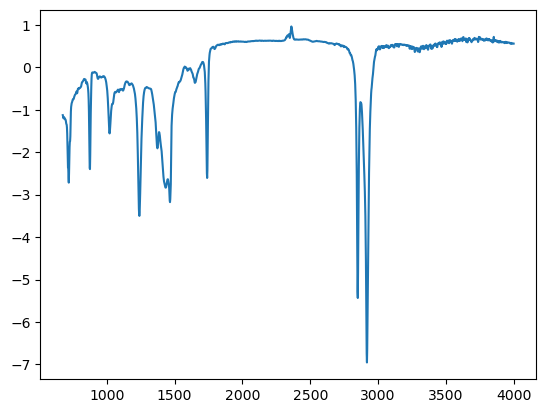

In [180]:
print(y_train[40])
_ = plt.plot(wl_list, X_train[40,:])

## Calculate HQI

In [21]:
# Pearson Correlation Coefficient
smx_p = smx_pcc(X_train, X_test, label_train)

# Nearest Neighbor
smx_n = smx_nn(X_train, X_test, label_train)

## Split calibration set from test set

In [151]:
cal_smx, val_smx, cal_labels, val_labels, idx = split_cal_test(smx_n, label_test, cal_prop=0.8, seed=3)
n = cal_smx.shape[0]
test_index = np.where(~idx)[0]
y_val = label_table.iloc[val_labels, 1].to_numpy()

## Perform Conformal Prediction over the test set

In [118]:
# Set confidence level 1 - alpha
alpha = 0.1
(prediction_sets, empirical_coverage), qhat = conform_pref(cal_smx, val_smx, cal_labels, n, alpha, val_labels, cond=0)

In [120]:
print('Threshold used: '+str(int(100*(1-qhat))/100))
print('Empirical coverage: '+str(int(100*empirical_coverage)/100))
print('Mean prediction set size: '+str(np.round(prediction_sets.sum(1).mean(), 2)))

Threshold used: 0.88
Empirical coverage: 0.94
Mean prediction set size: 1.82


In [129]:
prediction_sets_n = [list(label_table.loc[ps,'polymer']) for ps in prediction_sets]
prediction_sets_size = np.array([len(ps) for ps in prediction_sets_n])

In [164]:
zero_label = np.where(prediction_sets_size == 0)[0]
single_label = np.where(prediction_sets_size == 1)[0]
mult_label = np.where(prediction_sets_size > 1)[0]

print('Sets with zero labels: ' + str(zero_label.shape[0]))
print('Sets with one label: ' + str(single_label.shape[0]))
print('Sets with >1 labels: ' + str(mult_label.shape[0]))

Sets with zero labels: 0
Sets with one label: 27
Sets with >1 labels: 11


In [176]:
print('accuracy of single labels: ' +str(np.mean([prediction_sets_n[i][0]==y_val[i] for i in single_label])))

accuracy of single labels: 1.0


In [172]:
[prediction_sets_n[i] for i in single_label]

[['Cotton'],
 ['Cotton'],
 ['Cotton'],
 ['Polyamide'],
 ['Polyamide'],
 ['Polyethylene'],
 ['Polyethylene'],
 ['Polyethylene'],
 ['Polyethylene'],
 ['Polyethylene'],
 ['Polyethylene'],
 ['Polyethylene Terephthalate'],
 ['Polyethylene Terephthalate'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Polypropylene'],
 ['Polystyrene'],
 ['Polyurethane'],
 ['Polyvinyl Chloride'],
 ['Polyvinyl Chloride']]

## Manually check

['Acrylonitrile Butadiene Styrene', 'Cotton', 'Polyethylene', 'Polyethylene Vinyl Acetate', 'Polyvinyl Chloride', 'Rubber']


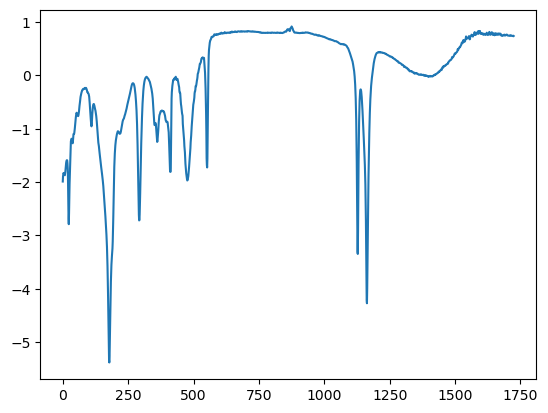

['Polyamide', 'Polystyrene']


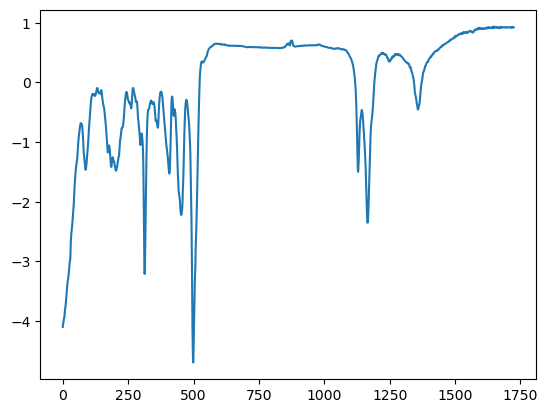

['Polyethylene', 'Polyethylene Vinyl Acetate']


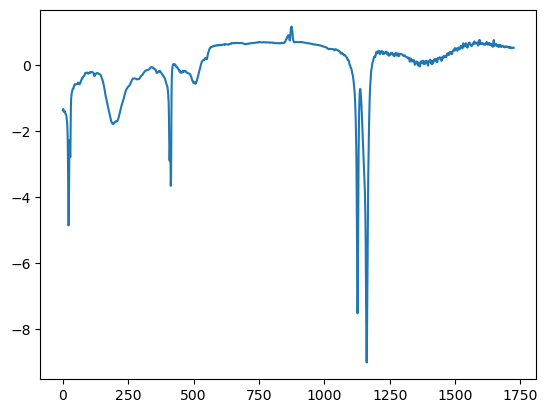

['Polyethylene', 'Polyethylene Vinyl Acetate']


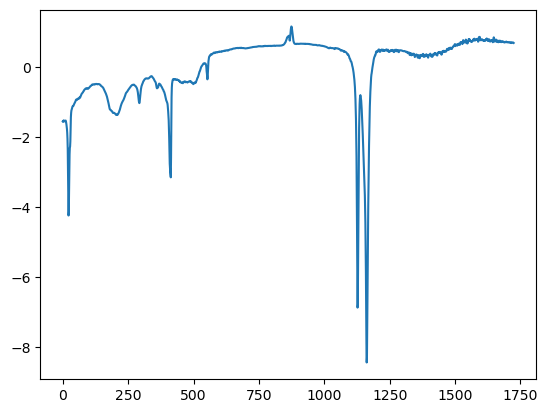

['Polyethylene', 'Polyethylene Vinyl Acetate']


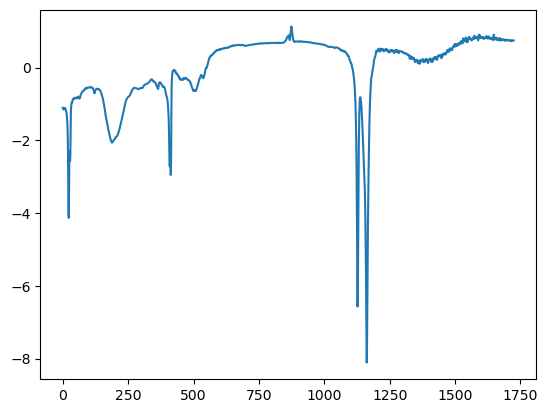

['Polypropylene', 'Rubber']


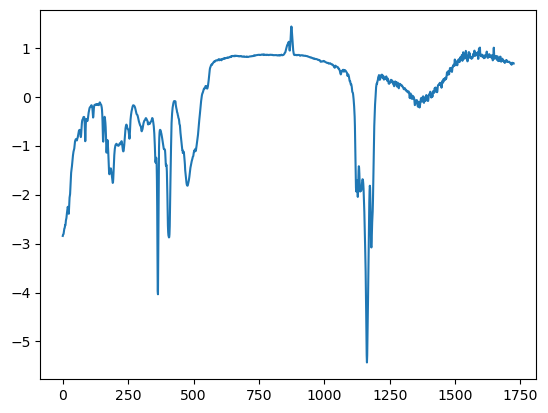

['Cotton', 'Polyamide', 'Polyethylene Terephthalate', 'Polyethylene Vinyl Acetate', 'Polypropylene', 'Polystyrene', 'Polyurethane', 'Polyvinyl Chloride', 'Rubber']


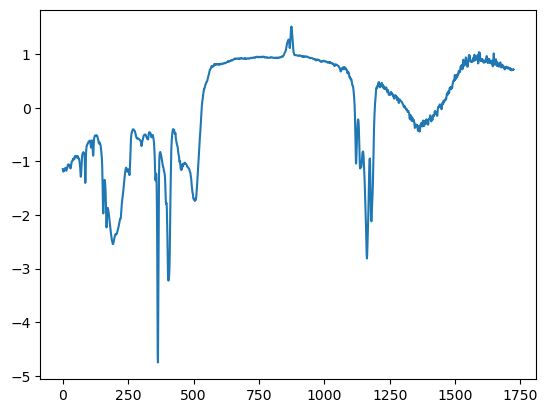

['Acrylonitrile Butadiene Styrene', 'Cotton', 'Polystyrene', 'Polyurethane', 'Polyvinyl Chloride', 'Rubber']


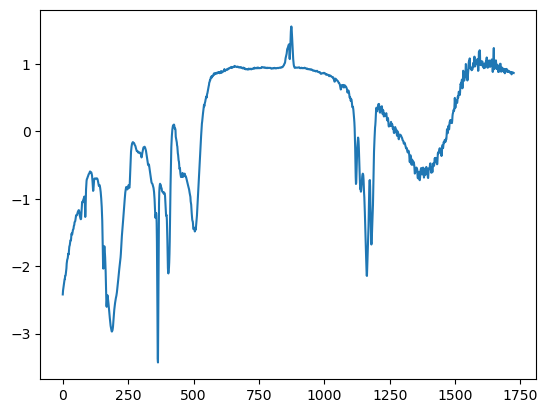

['Cotton', 'Polyurethane', 'Polyvinyl Chloride', 'Rubber']


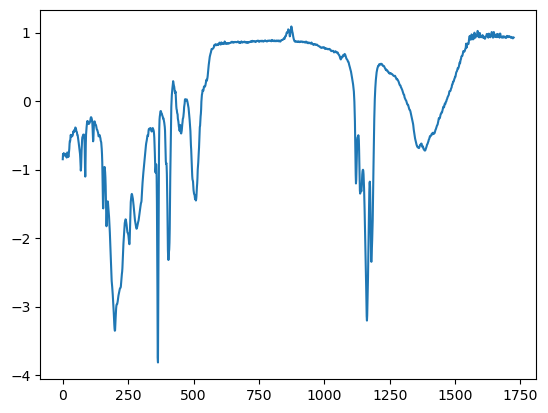

['Polyethylene Terephthalate', 'Polyurethane', 'Polyvinyl Chloride']


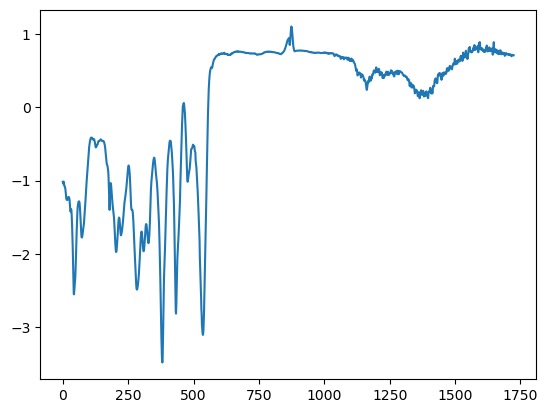

['Acrylic', 'Polyethylene Terephthalate', 'Polyurethane', 'Polyvinyl Chloride']


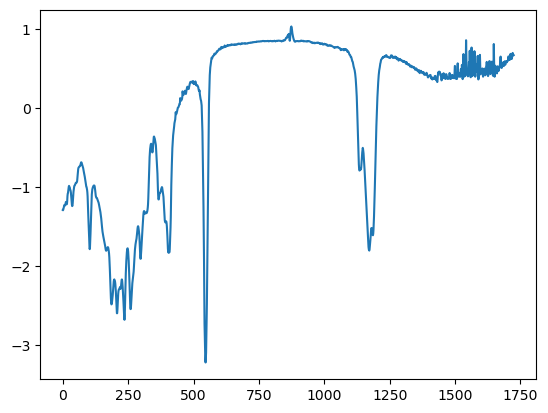

In [155]:
for i in mult_label:
    j = test_index[i]
    print(prediction_sets_n[i])
    plt.plot(X_test[j])
    plt.show()